In [5]:
%matplotlib inline
import gc
import fpfs
import simutil
import galsim
import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

In [11]:
def analyze(rng, num_gals, noise_level, shear_true, version=0):
    scale    = 0.263
    x  = []
    y  = []
    y_err= []
    backgrounds = []

    img,psf=simutil.make_data(rng, shear_true, scale)
    
    ngrid   =   img.shape[0]
    flux_gal=   np.sum(img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    ngrid   =   psf.shape[0]
    rcut    =   16
    beg     =   ngrid//2-rcut
    end     =   beg+2*rcut
    # cutout PSF into 32x32 grids
    psf     =   psf[beg:end,beg:end] 
    
    num_tests = len(noise_level)
    for i in range(num_tests):
        noii    =   noise_level[i]
        x.append(flux_gal/(noii*5))
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf,noiFit=noii**2.,beta=0.75)
        results =   []
        #makes first true for every new noise value
        first   = True
        for j in range(num_gals):
            galDict,psfDict,_ =   simutil.add_noise(img,psf,scale,rng,noii,version,first)
            # cut out galaxy into 32x32 grids
            gal= galDict['im']
            ngrid=   gal.shape[0]
            beg  =   ngrid//2-rcut
            end  =   beg+2*rcut
            gal  =   gal[beg:end,beg:end]
            # FPFS measurement
            modes=  fpTask.measure(gal)
            # append measured modes to the results list
            results.append(modes)
            del gal,modes,beg,end,ngrid,galDict,psfDict
            if first:
                first = False
        mms =   rfn.stack_arrays(results,usemask=False)
        ells=   fpfs.fpfsBase.fpfsM2E(mms,const=2000,noirev=False)
        del mms,results
        resp=np.average(ells['fpfs_RE'])
        shear=np.average(ells['fpfs_e1'])/resp
        shear_err=np.std(ells['fpfs_e1'])/np.abs(resp)/np.sqrt(num_gals)
        y.append(shear)
        y_err.append(shear_err)
        gc.collect()
    return np.array(x),np.array(y), np.array(y_err)

In [7]:
rng=np.random.RandomState(1024)
noise_arr = 1e5*np.logspace(-4, -2, 5, base=10.0)
num_gals = 4000
shear_true = [0.01, 0.00]

In [8]:
ans1 = analyze(rng, num_gals, noise_arr, shear_true, version=0)
print("x =", ans1[0])
print("y =", ans1[1])
print("yerr =", ans1[2])

x = [1004.50554688  317.65254504  100.45055469   31.7652545    10.04505547]
y = [0.00999006 0.00993935 0.01013268 0.00787302 0.01197396]
yerr = [4.05601063e-05 1.25814466e-04 3.89765202e-04 1.26968667e-03
 4.15085942e-03]


In [9]:
ans2 = analyze(rng, num_gals, noise_arr, shear_true, version=1)
print("x =", ans2[0])
print("y =", ans2[1])
print("yerr =", ans2[2])

x = [957.58132813 302.81380417  95.75813281  30.28138042   9.57581328]
y = [0.00982594 0.00994266 0.01024916 0.01191481 0.01264119]
yerr = [7.93725696e-05 1.42525597e-04 3.97756810e-04 1.26164889e-03
 4.24720368e-03]


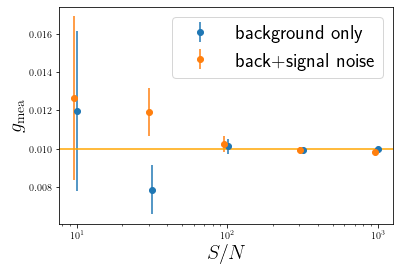

In [15]:
plt.errorbar(ans1[0], ans1[1], yerr=ans1[2], fmt='o', label='background only')
plt.errorbar(ans2[0], ans2[1], yerr=ans2[2], fmt='o', label='back+signal noise')
plt.axhline(shear_true[0], color="orange")
plt.xscale("log")
plt.xlabel(r'$S/N$', fontsize=20)
plt.ylabel(r'$g_{\rm mea}$', fontsize=20)
plt.legend(fontsize=20)